In [1]:
import pandas as pd
import folium
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
import libpysal
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import networkx as nx
import numpy as np
import logging
import requests_cache
import requests
import json
from math import radians, cos, sin, asin, sqrt
from haversine import haversine

In [2]:
df = pd.read_csv(r"C:\Users\marco\Downloads\Electric_Vehicle_Charging_Stations_in_New_York (1).csv")

In [3]:
df['Year'] = df['Open Date'].str[6:]
df = df.fillna(value=0)
df = df.drop(['Fuel Type Code', 'Intersection Directions','Station Phone','Status Code','Owner Type Code',
         'Federal Agency ID','Federal Agency Name','Cards Accepted',
         'EV Network Web','ZIP','Groups With Access Code','Expected Date','Access Days Time',
         'Geocode Status','Updated At','Plus4','Date Last Confirmed',"EV Other Info","Open Date"], axis=1)

In [4]:
df.tail(50)

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
3209,"Montauk, NY - Tesla Supercharger",70 South Euclid Avenue,Montauk,NY,0.0,0.0,8.0,Tesla,41.036062,-71.943509,170431,TESLA,2020
3210,Ultralife Corporation,2000 Technology Parkway,"Newark,",NY,0.0,2.0,0.0,EV Connect,43.026445,-77.091189,154908,J1772,2019
3211,Boiler ER Lot,2157 Main St Buffalo,Buffalo,NY,0.0,2.0,0.0,EV Connect,42.927789,-78.847434,202631,J1772,2021
3212,LPCL STATION1,30 Lake Placid Club Way,Lake Placid,NY,0.0,2.0,0.0,ChargePoint Network,44.283206,-73.979572,123468,J1772,2019
3213,Icon Parking 560 Third Ave - Tesla Destination,560 3rd Ave,New York,NY,0.0,3.0,0.0,Tesla Destination,40.747962,-73.976569,115162,J1772 TESLA,2016
3214,Walmart 1949 Fredonia,10401 Bennett Road,Fredonia,NY,0.0,0.0,4.0,Electrify America,42.453790,-79.311180,168359,CHADEMO J1772COMBO,2020
3215,Hilton Garden Inn Watertown - Tesla Destination,1290 Arsenal St,Watertown,NY,0.0,2.0,0.0,Tesla Destination,43.979571,-75.946973,115246,J1772 TESLA,2016
3216,West Genesee Athletic Club,6415 Pottery Rd,Warens,NY,0.0,2.0,0.0,LIVINGSTON,43.080330,-76.284060,223135,J1772,2021
3217,854ELLICOTT 134 HIGH ST 9,134 High St,Buffalo,NY,0.0,2.0,0.0,ChargePoint Network,42.901006,-78.863905,181848,J1772,2021
3218,"CDTA CDTA #2, SOUTH",122 Industrial Park Rd,Albany,NY,0.0,2.0,0.0,ChargePoint Network,42.679626,-73.779698,186566,J1772,2021


In [5]:
occurrences = df['EV_Network'].value_counts()
print(occurrences)

ChargePoint Network    1619
Tesla Destination       469
Non-Networked           273
LIVINGSTON              256
EV Connect              241
Blink Network            96
Tesla                    80
FLO                      47
Electrify America        38
Volta                    31
AMPUP                    30
SHELL_RECHARGE           24
eVgo Network             23
SemaCharge Network       19
RIVIAN_WAYPOINTS          4
SWTCH                     3
OpConnect                 3
EVGATEWAY                 1
FLASH                     1
CHARGELAB                 1
Name: EV_Network, dtype: int64


I 4 maggiori Network di ricarica appartengono a Tesla, Charge Point Network e Livingston, e quelli che non sono compresi in nessun network specifico.

Vengono eliminate le colonne che non presentano dati utili all'analisi o che presentano dei NaN in ogni osservazione.

In [6]:
df.index.names = ['Index']
df = df.fillna(value=0)
df.shape

(3259, 13)

Il dataset presenta 3261 osservazioni, solo relative allo stato di New York. 

In [7]:
df =df.reset_index(drop=True)

In [8]:
df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
0,St. George Courthouse,54 Central Ave,Staten Island,NY,0.0,5.0,0.0,EV Connect,40.639469,-74.076912,65296,J1772,2016
1,RRH RIEDMAN CAMP10,100 Kings Hwy S,Rochester,NY,0.0,2.0,0.0,ChargePoint Network,43.201826,-77.574561,121386,J1772,2019
2,Avon,74 Genesee Street,Avon,NY,0.0,2.0,0.0,EV Connect,42.910944,-77.746320,123132,J1772,2019
3,SKIDMORE SUSSMAN,Lower Scribner Village Rd,Saratoga Springs,NY,0.0,2.0,0.0,ChargePoint Network,43.098653,-73.789220,123552,J1772,2019
4,WARRENCOUNTY DPW 2,1344 U.S. 9,Lake George,NY,0.0,2.0,0.0,ChargePoint Network,43.359015,-73.701099,150258,J1772,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,1285 MAIN 1285 MAIN (1),1285 Main St,Buffalo,NY,0.0,2.0,0.0,ChargePoint Network,42.908237,-78.866359,154372,J1772,2020
3255,532 W 122nd St,532 W 122nd St,New York,NY,0.0,4.0,0.0,EV Connect,40.811446,-73.960477,168414,J1772,2020
3256,BNL NSLS-II LOB-4,Loop Rd,Upton,NY,0.0,2.0,0.0,Non-Networked,40.862723,-72.872473,184440,J1772,2021
3257,TANNERSVILLE MUNICIPAL LOT,20 Tompkins St,Tannersville,NY,0.0,2.0,0.0,ChargePoint Network,42.195133,-74.132420,152438,J1772,2020


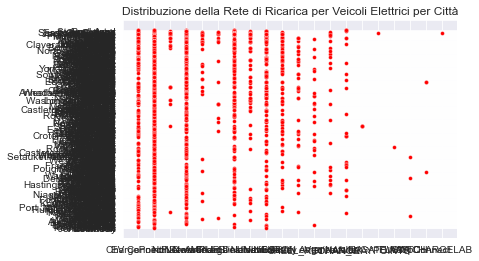

In [9]:
sns.set_style('darkgrid')
sns.scatterplot(x='EV_Network', y='City', data=df, s=15, color='red')
# Imposta il titolo e le etichette degli assi
plt.title("Distribuzione della Rete di Ricarica per Veicoli Elettrici per Città")
plt.xlabel("")
plt.ylabel("")

# Mostra il grafico
plt.show()

Plot della mappa

In [10]:
location = df[["Latitude", "Longitude", "Station Name","EV_Network","ID"]]

In [11]:
# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()

In [12]:
maps = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=0.5, control_scale=True)
location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["Station Name"]).add_to(map), axis=1)
# maps

AttributeError: type object 'map' has no attribute 'add_child'

Calcolo distanza e tempo di guida da una colonnina alla successiva

In [13]:
# df["Distance"],df["Duration"]="",""

Calcolo della distanza tramite Open Street Map

In [14]:
API_key = '96dd7cb32a8d43a1b8c78d219b21d381'
url = 'http://router.project-osrm.org/route/v1/driving/'

In [15]:
def getDistances(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['distance']/1000 #in km
    else:
        return 0

In [16]:
def getDuration(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['duration']/60 #in min
    else:
        return 0

In questo modo otterremo la distanza (in miglia) tra una colonnina e la successiva

In [17]:
# df = df.sort_values(by=["City",'Latitude', 'Longitude'])

In [18]:
# df["Next Latitude"] = df["Latitude"].shift(-1)
# df["Next Longitude"] = df["Longitude"].shift(-1)

Divido il dataset in 4 (uno per ogni network) in modo da poter confrontare i pattern di posizionamento.

In [19]:
df = df.reset_index(drop=True)

In [20]:
df.shape

(3259, 13)

In [21]:
# df["Distance"]  = df.apply(getDistances, axis = 1)
# df["Duration"]  = df.apply(getDuration, axis = 1)

In [22]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert coordinates to radians
    lon1, lat1, lon2, lat2 = __builtins__.map(radians, [lon1, lat1, lon2, lat2])

    # Calculate the difference in longitude and latitude
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the Haversine formula
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))

    r = 6371  # Radius of Earth in km. Use 3956 for miles
    return c * r

def distance_matrix(dataframe):
    # Calculate the geodesic distance matrix between all pairs of coordinates
    matrix = []
    for i in range(len(dataframe)):
        row = []
        for j in range(len(dataframe)):
            if i == j:
                row.append(0)
            else:
                dist = haversine(dataframe.iloc[i]['Latitude'], dataframe.iloc[i]['Longitude'], 
                                 dataframe.iloc[j]['Latitude'], dataframe.iloc[j]['Longitude'])
                row.append(dist)
        matrix.append(row)
    
    # Convert the matrix to a DataFrame
    df_matrix = pd.DataFrame(matrix, index=dataframe.index, columns=dataframe.index)
    
    return df_matrix

In [23]:
dist_matrix = distance_matrix(df)

In [25]:
dist_matrix.mean().mean()

227.47105699957396

In [26]:
print(dist_matrix)

            0           1           2           3           4           5     \
0       0.000000  406.034693  395.385775  274.483928  303.989139  221.922685   
1     406.034693    0.000000   35.226646  307.268793  314.017823  322.434741   
2     395.385775   35.226646    0.000000  322.423425  331.970371  332.162613   
3     274.483928  307.268793  322.423425    0.000000   29.818261   54.303705   
4     303.989139  314.017823  331.970371   29.818261    0.000000   82.733667   
...          ...         ...         ...         ...         ...         ...   
3254  470.403662  109.916884   91.218468  413.343222  422.055531  423.196418   
3255   21.493234  399.702152  390.822575  254.719612  284.083819  201.731436   
3256  104.449075  467.289720  463.193703  259.910734  285.862652  206.503287   
3257  173.043846  302.718931  306.507279  104.314160  134.119623   58.795740   
3258  268.120203  302.665009  317.198044    7.817307   36.989778   49.424929   

            6           7           8  

In [27]:
dist_matrix.quantile(0.25).mean()

111.06008879347186

In [28]:
dist_matrix.quantile(0.75).mean()

316.28429007019105

In [29]:
nonzero_vals = dist_matrix[dist_matrix != 0]
min_val = nonzero_vals.min()
print(min_val.min())

0.00013782380842475506


In [30]:
dist_matrix.max().max()

649.7855156117278

In [31]:
def create_graphs(df):
    # Convert 'Year' column to int type
    df['Year'] = df['Year'].astype(int)
    
    # Group dataframe by year
    df_grouped = df.groupby('Year')

    # Create a graph for each year with only values up to that year
    for year, df_year in df_grouped:
        # Filter dataframe to only include rows up to the current year
        df_filtered = df[df['Year'] <= year]

        # Initialize graph
        G = nx.Graph()

        # Add nodes to graph
        for i, row in df_filtered.iterrows():
            G.add_node(i, pos=(row['Latitude'], row['Longitude']))

        # Add edges to graph
        for i, row1 in df_filtered.iterrows():
            for j, row2 in df_filtered.loc[row1.name+1:].iterrows():
                p1 = row1[['Latitude', 'Longitude']].to_numpy()
                p2 = row2[['Latitude', 'Longitude']].to_numpy()
                dist = haversine(p1, p2)
                if dist <= 100:
                    G.add_edge(i, j)
        # Yield graph for current year
        yield year, G
        
        
# graphs = create_graphs(df)

# Iterate over the graphs for each year
# for year, G in graphs:
#     pos = nx.get_node_attributes(G, 'pos')
#     nx.draw(G, pos=pos, with_labels=False, node_size=20, node_color="red")
#     plt.title(f"Graph for Year {year}")
#     plt.show()


In [32]:
def create_graph(df):
    # Initialize graph
    G = nx.Graph()

    # Add nodes to graph
    for i, row in df.iterrows():
        G.add_node(i, pos=(row['Latitude'], row['Longitude']))

    # Add edges to graph
    for i, row1 in df.iterrows():
        for j, row2 in df.loc[row1.name+1:].iterrows():
            lat1, lon1 = row1['Latitude'], row1['Longitude']
            lat2, lon2 = row2['Latitude'], row2['Longitude']
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist <= 100:
                G.add_edge(i, j)

    return G


In [ ]:
G = create_graph(df)
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=20, node_color="red")
plt.show()

In [33]:
df["EV_Network"].value_counts()

ChargePoint Network    1619
Tesla Destination       469
Non-Networked           273
LIVINGSTON              256
EV Connect              241
Blink Network            96
Tesla                    80
FLO                      47
Electrify America        38
Volta                    31
AMPUP                    30
SHELL_RECHARGE           24
eVgo Network             23
SemaCharge Network       19
RIVIAN_WAYPOINTS          4
SWTCH                     3
OpConnect                 3
EVGATEWAY                 1
FLASH                     1
CHARGELAB                 1
Name: EV_Network, dtype: int64

In [49]:
values=["Tesla","Tesla Destination"]
tesla_df = df[df.EV_Network.isin(values)]
cpn_df = df[df['EV_Network'] =="ChargePoint Network"]
l_df = df[df['EV_Network'] =="LIVINGSTON"]

In [50]:
tesla_df =tesla_df.reset_index(drop=True)
cpn_df =cpn_df.reset_index(drop=True)
l_df =l_df.reset_index(drop=True)

Il grafo risultante per l'intero stato si presenta molto confuso e poco significativo. L'unica informazione che si può ottenere è la maggiore concentrazione nelle aree urbane a densità maggiore, come si poteva facilmente prevedere: ad esempio le città di New York e Buffalo

In [51]:
tesla_df.shape

(549, 13)

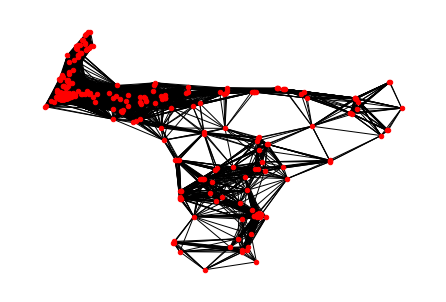

In [37]:
G = create_graph(tesla_df)

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=20, node_color="red")
plt.show() 

In [38]:
closeness = nx.closeness_centrality(G)
mean_closeness = np.mean(list(closeness.values()))

print("Media closeness centrality Tesla:", mean_closeness)

Media closeness centrality Tesla: 0.4815506321185232


In [39]:
betweenness = nx.betweenness_centrality(G)
mean_betweennes = np.mean(list(betweenness.values()))

print("Media betweennes centrality Tesla:", mean_betweennes)

Media betweennes centrality Tesla: 0.00243648076027154


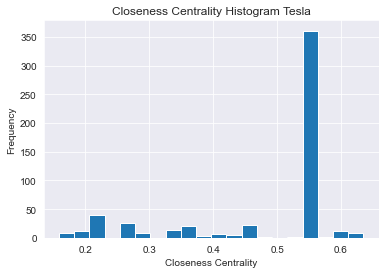

In [40]:
plt.hist(list(closeness.values()), bins=20)
plt.title("Closeness Centrality Histogram Tesla")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.show()

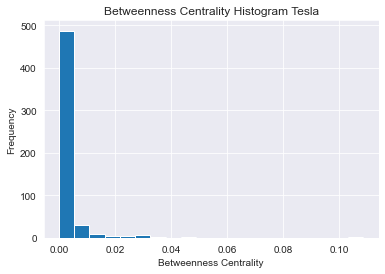

In [41]:
plt.hist(list(betweenness.values()), bins=20)
plt.title("Betweenness Centrality Histogram Tesla")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.show()

In [42]:
cpn_df.shape

(1619, 13)

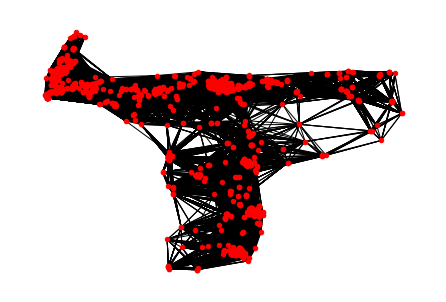

In [43]:
G = create_graph(cpn_df)

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=20, node_color="red")
plt.show()

In [44]:
closeness = nx.closeness_centrality(G)
mean_closeness = np.mean(list(closeness.values()))
print("Media closeness centrality Charge Point Network:", mean_closeness)

Media closeness centrality Charge Point Network: 0.35023928754762707


In [45]:
betweenness = nx.betweenness_centrality(G)
mean_betweennes = np.mean(list(betweenness.values()))

print("Media betweennes centrality Charge Point Network:", mean_betweennes)

Media betweennes centrality Charge Point Network: 0.0012171062640408596


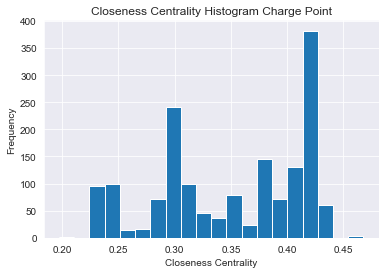

In [46]:
plt.hist(list(closeness.values()), bins=20)
plt.title("Closeness Centrality Histogram Charge Point")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.show()

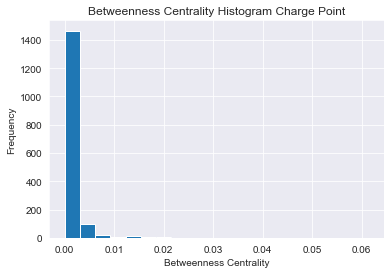

In [47]:
plt.hist(list(betweenness.values()), bins=20)
plt.title("Betweenness Centrality Histogram Charge Point")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.show()

In [52]:
l_df.shape

(256, 13)

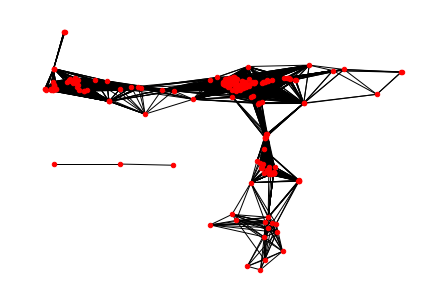

In [53]:
G = create_graph(l_df)

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=20, node_color="red")
plt.show()

In [58]:
closeness = nx.closeness_centrality(G)
mean_closeness = np.mean(list(closeness.values()))
print("Media closeness centrality LIVINGSTON:", mean_closeness)

Media closeness centrality LIVINGSTON: 0.39744369476326574


In [59]:
betweenness = nx.betweenness_centrality(G)
mean_betweennes = np.mean(list(betweenness.values()))

print("Media betweennes centrality LIVINGSTON:", mean_betweennes)

Media betweennes centrality LIVINGSTON: 0.00628425582831558


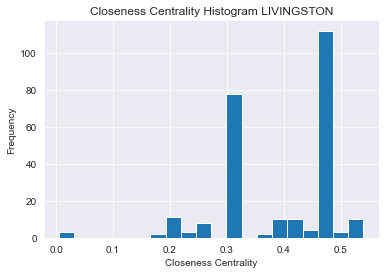

In [60]:
plt.hist(list(closeness.values()), bins=20)
plt.title("Closeness Centrality Histogram LIVINGSTON")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")
plt.show()

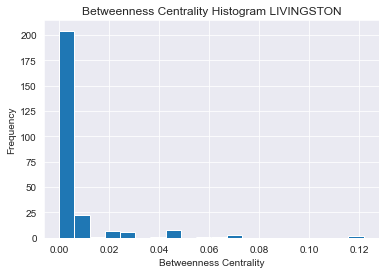

In [61]:
plt.hist(list(betweenness.values()), bins=20)
plt.title("Betweenness Centrality Histogram LIVINGSTON")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.show()